### Imports

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:20.2f}'.format

pd.set_option('display.max_Columns', 999)

### Read data into a dataframe

In [367]:
df = pd.read_excel('./online_retail_II.xlsx', sheet_name=0)

df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


### Information about Columns and the datatypes

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


### It is noticeable that both `Quantity` and `Price` have negative values, which is unusual.

In [369]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


### The `StockCode` and `Description` have different values, which might be worth examining more closely.

In [370]:
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


### Review of Customer ID NaNs:
- The `Customer ID` cannot be easily determined based on the other data, and it is not possible to assign these records to the existing `Customer ID`.
- These records will likely not be considered later.

In [371]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


### Review of Negative Quantity:
**Dataset Documentation:**
- **InvoiceNo:** Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.

- When an `Invoice` starts with the letter `C`, this transaction should be considered a cancellation, and a negative `Quantity` indicates the return of the product due to this cancellation.

In [372]:
df[df["Quantity"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


### Use Regex to filter all regular orders
- The string starts (^) followed by exactly 6 digits (\\{6}), and the match must end there ($).

In [373]:
df["Invoice"] = df["Invoice"].astype("str")
df[df["Invoice"].str.match("^\\d{6}$") == False].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
326731,C521265,85066,CREAM SWEETHEART MINI CHEST,-1,2010-09-03 11:30:00,12.75,17049.00,United Kingdom
209842,C509622,22178,VICTORIAN GLASS HANGING T-LIGHT,-7,2010-05-25 09:52:00,1.25,13295.00,United Kingdom
2983,C489643,20686,DOLLY MIXTURE CHILDREN'S UMBRELLA,-1,2009-12-01 16:26:00,3.25,15750.00,United Kingdom
132395,C501914,21359,RELAX LARGE WOOD LETTERS,-1,2010-03-22 09:40:00,15.95,13151.00,United Kingdom
199165,C508499,21232,STRAWBERRY CERAMIC TRINKET BOX,-3,2010-05-16 15:21:00,1.06,13798.00,United Kingdom
217419,C510494,84932C,SMALL ORIENTAL BLUE FOLDING STOOL,-1,2010-06-01 12:30:00,8.50,13544.00,United Kingdom
275712,C516180,21389,IVORY HANGING DECORATION BIRD,-1,2010-07-18 14:37:00,0.85,14546.00,United Kingdom
275088,C516149,21080,SET/20 RED SPOTTY PAPER NAPKINS,-1,2010-07-18 10:52:00,0.85,13798.00,United Kingdom
296564,C518254,22180,RETRO SPOT LAMP,-1,2010-08-05 18:09:00,9.95,12525.00,France
203418,C509015,21937,STRAWBERRY PICNIC BAG,-3,2010-05-19 13:36:00,2.95,14598.00,United Kingdom


### Use Regex to check if there are other starting letters in the Invoices
- Replace all 6-digit `Invoice` numbers with an empty string, so that the digits are not included in the selection.

In [374]:
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

array(['', 'C', 'A'], dtype=object)

### Use Regex to check what 'A' and 'C' could represent in the Invoice

In [375]:
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [376]:
df[df["Invoice"].str.startswith("C")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.00,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.00,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.00,United Kingdom


### Review of the dataset documentation regarding StockCode
**Dataset Documentation:**
- **StockCode:** Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
  
- Here we see that around 80,000 out of the approximately 520,000 rows do not fit the documentation and are not further categorized. However, the StockCodes that have a letter at the end seem to fit well with the rest of the data.

In [377]:
df["StockCode"] = df["StockCode"].astype("str")
df[df["StockCode"].str.match("^\\d{5}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


### Now let's take a closer look at the StockCodes and, in addition to the 5-digit StockCodes, also include those with 5 digits followed by a letter and review the rest
- We notice that there are also repetitive letters following the 5 digits, which also seem fine.
- We will include those in the next step as well.

In [378]:
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]$") == False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.00,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.00,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.00,Belgium
572,489522,79323LP,LIGHT PINK CHERRY LIGHTS,1,2009-12-01 11:45:00,6.75,15998.00,United Kingdom
613,489526,15056BL,EDWARDIAN PARASOL BLACK,6,2009-12-01 11:50:00,5.95,12533.00,Germany
...,...,...,...,...,...,...,...,...
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525006,538153,15056bl,EDWARDIAN PARASOL BLACK,1,2010-12-09 16:31:00,12.72,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


### The repetitive letters following the 5 digits have been included by adding the + symbol to the end of the regex to capture one or more letters after the digits.

In [379]:
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.00,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.00,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.00,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,12533.00,Germany
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299.00,United Kingdom
...,...,...,...,...,...,...,...,...
524776,538147,M,Manual,1,2010-12-09 16:11:00,15.00,13090.00,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


### Now examine all the StockCodes that do not follow our regular pattern.

In [380]:
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

### Review and Evaluation of the StockCodes that do not follow the regular pattern

In [381]:
# Looks like valid data, represents postage, exclude
df[df["StockCode"].str.contains("^POST")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.00,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.00,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.00,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,12533.00,Germany
927,C489538,POST,POSTAGE,-1,2009-12-01 12:18:00,9.58,15796.00,United Kingdom
...,...,...,...,...,...,...,...,...
522916,537967,POST,POSTAGE,1,2010-12-09 11:31:00,18.00,12494.00,France
522930,537995,POST,POSTAGE,2,2010-12-09 11:39:00,18.00,12712.00,Germany
522974,538003,POST,POSTAGE,8,2010-12-09 12:05:00,18.00,12429.00,Denmark
523064,538008,POST,POSTAGE,5,2010-12-09 12:17:00,18.00,12683.00,France


In [382]:
# Looks like valid data, represents discount, exclude
df[df["StockCode"].str.contains("^D$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299.00,United Kingdom
736,C489535,D,Discount,-1,2009-12-01 12:11:00,19.00,15299.00,United Kingdom
24675,C491428,D,Discount,-1,2009-12-10 20:23:00,9.10,15494.00,United Kingdom
29414,C491845,D,Discount,-1,2009-12-14 14:54:00,1.59,NaN,United Kingdom
29958,C491962,D,Discount,-1,2009-12-14 16:38:00,0.59,13206.00,United Kingdom
...,...,...,...,...,...,...,...,...
501237,536158,D,Discount,1,2010-11-30 11:57:00,32.29,13634.00,United Kingdom
503073,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.00,United Kingdom
511955,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.00,United Kingdom
517436,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.00,United Kingdom


In [383]:
# Looks like valid data, Customer ID is NaN, exclude
df[df["StockCode"].str.contains("^DCGS") & df["Customer ID"].isna()].head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2377,489597,DCGS0058,MISO PRETTY GUM,1,2009-12-01 14:28:00,0.83,NaN,United Kingdom
2378,489597,DCGS0068,DOGS NIGHT COLLAR,1,2009-12-01 14:28:00,8.65,NaN,United Kingdom
8371,490074,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2009-12-03 14:39:00,17.35,NaN,United Kingdom
8372,490074,DCGS0058,MISO PRETTY GUM,1,2009-12-03 14:39:00,0.83,NaN,United Kingdom
8373,490074,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-03 14:39:00,16.48,NaN,United Kingdom


In [384]:
df[df["StockCode"].str.contains("^DCGS") & df["Customer ID"].notna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [385]:
# Looks like valid data, represents postage, Customed ID is null, exclude
df[df["StockCode"].str.contains("^DOT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-12-09 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [386]:
# Looks like valid data, represents manual transactions, exclude
df[df["StockCode"].str.contains("^[mM]")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2697,489609,M,Manual,1,2009-12-01 14:50:00,4.00,NaN,United Kingdom
3053,C489651,M,Manual,-1,2009-12-01 16:48:00,5.10,17804.00,United Kingdom
5897,C489859,M,Manual,-1,2009-12-02 14:45:00,69.57,NaN,United Kingdom
9259,C490126,M,Manual,-1,2009-12-03 18:12:00,5.95,15884.00,United Kingdom
9307,C490129,M,Manual,-1,2009-12-03 18:26:00,1998.49,15482.00,United Kingdom
...,...,...,...,...,...,...,...,...
521074,537800,M,Manual,12,2010-12-08 13:08:00,0.19,12748.00,United Kingdom
521122,537804,M,Manual,12,2010-12-08 13:17:00,2.95,12748.00,United Kingdom
521124,537804,M,Manual,12,2010-12-08 13:17:00,0.19,12748.00,United Kingdom
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom


In [387]:
# Looks like transport transactions, exclude
df[df["StockCode"].str.contains("^C[23]$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
9292,490127,C2,CARRIAGE,1,2009-12-03 18:13:00,50.00,14156.00,EIRE
14481,490541,C2,CARRIAGE,1,2009-12-07 09:25:00,50.00,NaN,EIRE
14502,490542,C2,CARRIAGE,1,2009-12-07 09:42:00,50.00,14911.00,EIRE
19541,490998,C2,CARRIAGE,1,2009-12-08 17:24:00,50.00,16253.00,United Kingdom
22803,491160,C2,CARRIAGE,1,2009-12-10 10:29:00,50.00,14911.00,EIRE
...,...,...,...,...,...,...,...,...
504361,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911.00,EIRE
515057,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.00,14911.00,EIRE
515390,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.00,14911.00,EIRE
522913,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.00,13369.00,United Kingdom


In [388]:
# Looks like valid data, represents gift cards, Customed ID is null, exclude
df[df["StockCode"].str.contains(r"gift", case=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
30620,491968,gift_0001_80,NaN,2,2009-12-14 17:56:00,0.00,NaN,United Kingdom
31079,491969,gift_0001_80,Dotcomgiftshop Gift Voucher £80.00,1,2009-12-14 17:57:00,69.56,NaN,United Kingdom
32048,491971,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,2,2009-12-14 18:37:00,17.39,NaN,United Kingdom
40904,492782,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2009-12-18 17:06:00,8.69,NaN,United Kingdom
40905,492782,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2009-12-18 17:06:00,17.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
399538,527520,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-10-18 13:18:00,25.53,NaN,United Kingdom
407443,528382,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2010-10-21 18:01:00,34.04,NaN,United Kingdom
434320,530850,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-11-04 14:49:00,25.53,NaN,United Kingdom
442201,531489,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-11-08 15:02:00,8.51,NaN,United Kingdom


In [389]:
# Test data, exclude
df[df["StockCode"].str.contains("^TEST")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346.00,United Kingdom
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,12346.00,United Kingdom
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346.00,United Kingdom
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,12346.00,United Kingdom
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,12346.00,United Kingdom
44614,493294,TEST002,NaN,1,2009-12-22 15:15:00,0.00,NaN,United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.00,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.00,United Kingdom
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,12346.00,United Kingdom
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,12346.00,United Kingdom


In [390]:
# Looks like valid data for a product, include
df[df["StockCode"].str.contains("^PADS")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
62299,494914,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-19 17:04:00,0.00,16705.00,United Kingdom
74731,496222,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-29 13:53:00,0.00,13583.00,United Kingdom
77702,496473,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-01 15:38:00,0.00,17350.00,United Kingdom
79794,496643,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-03 11:58:00,0.00,13408.00,United Kingdom
90798,497935,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-15 10:47:00,0.00,13408.00,United Kingdom
97716,498562,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-21 12:03:00,0.00,15182.00,United Kingdom
101718,499056,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-24 13:46:00,0.00,13765.00,United Kingdom
104480,499399,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-26 13:26:00,0.00,14459.00,United Kingdom
123947,501176,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-15 11:00:00,0.00,14857.00,United Kingdom
156809,504332,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-04-12 16:30:00,0.00,12671.00,Germany


In [391]:
# Looks like valid data, represents transactions adjustments, exclude
df[df["StockCode"].str.contains("^ADJUST2?$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
70975,495732,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:20:00,96.46,NaN,EIRE
70976,495733,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:21:00,68.34,14911.00,EIRE
70977,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,201.56,12745.00,EIRE
70978,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,205.82,14911.00,EIRE
70979,C495737,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:23:00,10.50,16154.00,United Kingdom
...,...,...,...,...,...,...,...,...
208670,C509474,ADJUST,Adjustment by Peter on 24/05/2010 1,-1,2010-05-24 11:13:00,72.45,16422.00,United Kingdom
208671,C509475,ADJUST,Adjustment by Peter on 24/05/2010 1,-1,2010-05-24 11:13:00,358.47,17364.00,United Kingdom
249672,513564,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,300.13,17050.00,United Kingdom
249673,513566,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,358.47,17364.00,United Kingdom


In [392]:
# Looks like valid data, represents samples, exclude
df[df["StockCode"].str.contains("^S$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
114061,C500305,S,SAMPLES,-1,2010-03-07 10:59:00,73.80,NaN,United Kingdom
114083,C500309,S,SAMPLES,-1,2010-03-07 11:09:00,32.03,NaN,United Kingdom
133558,C502083,S,SAMPLES,-1,2010-03-22 15:50:00,170.37,NaN,United Kingdom
133582,C502088,S,SAMPLES,-1,2010-03-22 16:03:00,259.59,NaN,United Kingdom
136253,C502438,S,SAMPLES,-1,2010-03-24 13:11:00,605.18,NaN,United Kingdom
136259,C502442,S,SAMPLES,-1,2010-03-24 13:20:00,94.19,NaN,United Kingdom
181508,506601,S,SAMPLES,1,2010-04-30 14:49:00,73.80,NaN,United Kingdom
181509,C506602,S,SAMPLES,-1,2010-04-30 14:56:00,3.84,NaN,United Kingdom
181510,C506602,S,SAMPLES,-1,2010-04-30 14:56:00,3.55,NaN,United Kingdom
181511,C506602,S,SAMPLES,-1,2010-04-30 14:56:00,77.00,NaN,United Kingdom


In [393]:
# Not to sure whats this data means, Customer ID is null, exclude
df[df["StockCode"].str.contains("^B$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [394]:
# Bank charges, exclude
df[df["StockCode"].str.contains("^BANK CHARGES$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
18410,C490943,BANK CHARGES,Bank Charges,-1,2009-12-08 14:08:00,15.00,16703.00,United Kingdom
18466,490948,BANK CHARGES,Bank Charges,1,2009-12-08 14:29:00,15.00,16805.00,United Kingdom
33435,C492206,BANK CHARGES,Bank Charges,-1,2009-12-15 16:32:00,848.43,NaN,United Kingdom
55948,C494438,BANK CHARGES,Bank Charges,-1,2010-01-14 12:15:00,767.99,NaN,United Kingdom
94431,498269,BANK CHARGES,Bank Charges,1,2010-02-17 15:03:00,15.00,16928.00,United Kingdom
...,...,...,...,...,...,...,...,...
450634,C532203,BANK CHARGES,Bank Charges,-1,2010-11-11 12:31:00,15.00,NaN,United Kingdom
455268,532637,BANK CHARGES,Bank Charges,1,2010-11-12 16:18:00,15.00,13174.00,United Kingdom
493162,535474,BANK CHARGES,Bank Charges,1,2010-11-26 13:56:00,15.00,16928.00,United Kingdom
507344,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.00,15823.00,United Kingdom


In [395]:
# Looks like valid data, Customer ID is null, exclude
df[df["StockCode"].str.contains("^47503J $")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
260886,514532,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2010-07-05 10:07:00,16.13,NaN,United Kingdom


In [396]:
# Looks like valid data with a special item, could be included
df[df["StockCode"].str.contains("^SP1002$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
377066,525772,SP1002,KID'S CHALKBOARD/EASEL,1,2010-10-07 11:12:00,2.95,12748.00,United Kingdom
377387,525837,SP1002,KID'S CHALKBOARD/EASEL,4,2010-10-07 12:23:00,2.95,17841.00,United Kingdom
426694,530135,SP1002,NaN,-27,2010-11-01 15:33:00,0.00,NaN,United Kingdom


In [397]:
# Looks like extra fees for Amazon, exclude
df[df["StockCode"].str.contains("^AMAZONFEE$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
440688,C531400,AMAZONFEE,AMAZON FEE,-1,2010-11-08 10:08:00,6706.71,NaN,United Kingdom
440698,531411,AMAZONFEE,AMAZON FEE,1,2010-11-08 10:11:00,6706.71,NaN,United Kingdom
517452,C537600,AMAZONFEE,AMAZON FEE,-1,2010-12-07 12:41:00,1.00,NaN,United Kingdom
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
517955,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
519170,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom
519251,C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,5519.25,NaN,United Kingdom
519294,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom
519295,C537652,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:51:00,6706.71,NaN,United Kingdom


# Data cleaning

In [398]:
cleaned_df = df.copy()

### Cleaning Invoice, exclude the Invoices that start with c for cancelation and a where i am not to sure about for what it actually stands

In [399]:
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")

mask = (cleaned_df["Invoice"].str.match("^\\d{6}$") == True)

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [400]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

mask = (
        (cleaned_df["StockCode"].str.match("^\\d{5}$") == True) 
        | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True) 
        | (cleaned_df["StockCode"].str.match("^PADS$") == True)
    ) 

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


### There is still some leftover data that needs to be excluded, such as the NaN values in the Customer ID.

In [401]:
cleaned_df[cleaned_df["Customer ID"].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [402]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

/var/folders/1x/40xjqqbn4g972c4cp7dpn0qr0000gs/T/ipykernel_11951/1633333693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.dropna(subset=["Customer ID"], inplace=True)


In [403]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406337.00,406337,406337.00,406337.00
mean,13.62,2010-07-01 10:11:06.543288320,2.99,15373.63
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14004.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.37


In [404]:
len(cleaned_df)

406337

### There are some products in the records that have a price of 0. These will be excluded as well, since it is unclear why these products have no cost.

In [405]:
len(cleaned_df[cleaned_df["Price"] == 0])

28

In [406]:
cleaned_df[cleaned_df["Price"] == 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.00,16126.00,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.00,15658.00,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.00,15070.00,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.00,18071.00,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.00,14258.00,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.00,12417.00,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.00,16858.00,United Kingdom
111348,500073,21662,VINTAGE GLASS COFFEE CADDY,1,2010-03-04 11:44:00,0.00,13047.00,United Kingdom


In [407]:
cleaned_df = cleaned_df[cleaned_df["Price"] != 0.00]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


# Difference between the original DataFrame and the cleaned DataFrame
#### The cleaned DataFrame differs from the original DataFrame in several key ways:
Invalid StockCodes: StockCodes that did not follow the expected patterns were removed or corrected.
Cancellations: Invoices starting with "C", which indicate cancellations, were excluded.
Zero-priced products: Products with a price of 0 were filtered out, as their pricing is unclear.
NaN Customer IDs: Entries with missing Customer IDs were excluded, as these records could not be assigned to any customer.

In [409]:
print(len(cleaned_df) - len(df))
print(len(cleaned_df) / len(df))

-119152
0.7732429238325965


### Dropped 120k rows or about 23% of the original Dataframe

### Adding a new column for the total value of the transaction, so we can aggregate better

In [445]:
cleaned_df["Transaction Total"] = cleaned_df["Price"] * cleaned_df["Quantity"]
cleaned_df[cleaned_df["Customer ID"]==12346.00]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction Total
107800,499763,20682,RED SPOTTY CHILDS UMBRELLA,1,2010-03-02 13:08:00,3.25,12346.00,United Kingdom,3.25
107801,499763,20679,EDWARDIAN PARASOL RED,1,2010-03-02 13:08:00,5.95,12346.00,United Kingdom,5.95
107802,499763,15056N,EDWARDIAN PARASOL NATURAL,1,2010-03-02 13:08:00,5.95,12346.00,United Kingdom,5.95
107803,499763,15056BL,EDWARDIAN PARASOL BLACK,1,2010-03-02 13:08:00,5.95,12346.00,United Kingdom,5.95
107804,499763,15056P,EDWARDIAN PARASOL PINK,1,2010-03-02 13:08:00,5.95,12346.00,United Kingdom,5.95
253028,513774,21524,DOORMAT SPOTTY HOME SWEET HOME,1,2010-06-28 13:53:00,7.49,12346.00,United Kingdom,7.49
253029,513774,22692,DOORMAT WELCOME TO OUR HOME,1,2010-06-28 13:53:00,7.49,12346.00,United Kingdom,7.49
253030,513774,22660,DOORMAT I LOVE LONDON,1,2010-06-28 13:53:00,7.49,12346.00,United Kingdom,7.49
253031,513774,22687,DOORMAT CHRISTMAS VILLAGE,1,2010-06-28 13:53:00,7.49,12346.00,United Kingdom,7.49
253032,513774,48173C,DOORMAT BLACK FLOCK,1,2010-06-28 13:53:00,7.49,12346.00,United Kingdom,7.49


### Creating an aggregated dataframe with 3 new columns.
- The total value spent per customer
- The frequency of orders
- The date of the last order

In [447]:
agg_df = cleaned_df.groupby(by="Customer ID", as_index=False).agg(
    TotalValuePerCustomer=("Transaction Total", "sum"),
    Frequency=("Invoice", "nunique"),
    LastInvoiceDatePerCustomer=("InvoiceDate", "max"))
agg_df

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer
0,12346.00,169.36,2,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,221.16,1,2010-09-27 14:59:00
3,12349.00,2221.14,2,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00
...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00
4281,18284.00,411.68,1,2010-10-04 11:33:00
4282,18285.00,377.00,1,2010-02-17 10:24:00
4283,18286.00,1246.43,2,2010-08-20 11:57:00


### Adding a Column for Recency to Measure Time Since the Last Order
We are adding a new column to calculate the recency, which represents how long it has been since the customer's last order, based on the most recent order date. In real-world scenarios, this would typically be calculated relative to the current date.

In [448]:
max_invoice_date = agg_df["LastInvoiceDatePerCustomer"].max()

agg_df["Recency"] = (max_invoice_date - agg_df["LastInvoiceDatePerCustomer"]).dt.days

agg_df.head(5)

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer,Recency
0,12346.00,169.36,2,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73
3,12349.00,2221.14,2,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10


### Plotting the Distribution of the Obtained Information to Identify Outliers for Potential Handling Before Data Clustering

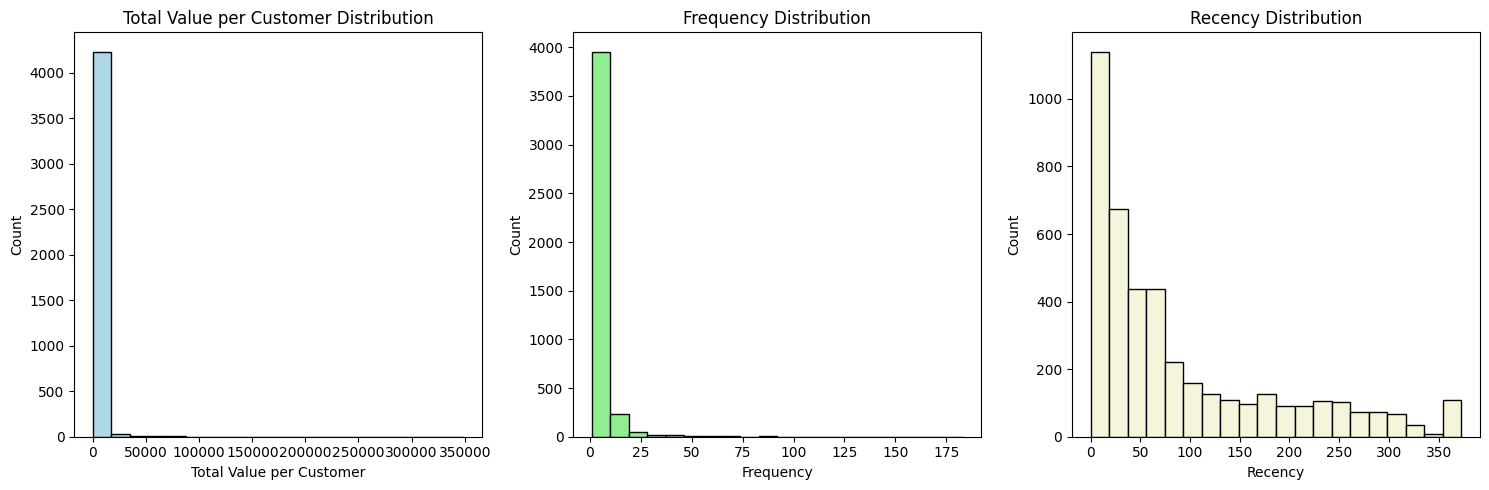

In [460]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(agg_df["TotalValuePerCustomer"], bins=20, color='lightblue', edgecolor='black')
plt.title("Total Value per Customer Distribution")
plt.xlabel("Total Value per Customer")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.hist(agg_df["Frequency"], bins=20, color='lightgreen', edgecolor='black')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
plt.hist(agg_df["Recency"], bins=20, color='beige', edgecolor='black')
plt.title("Recency Distribution")
plt.xlabel("Recency")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

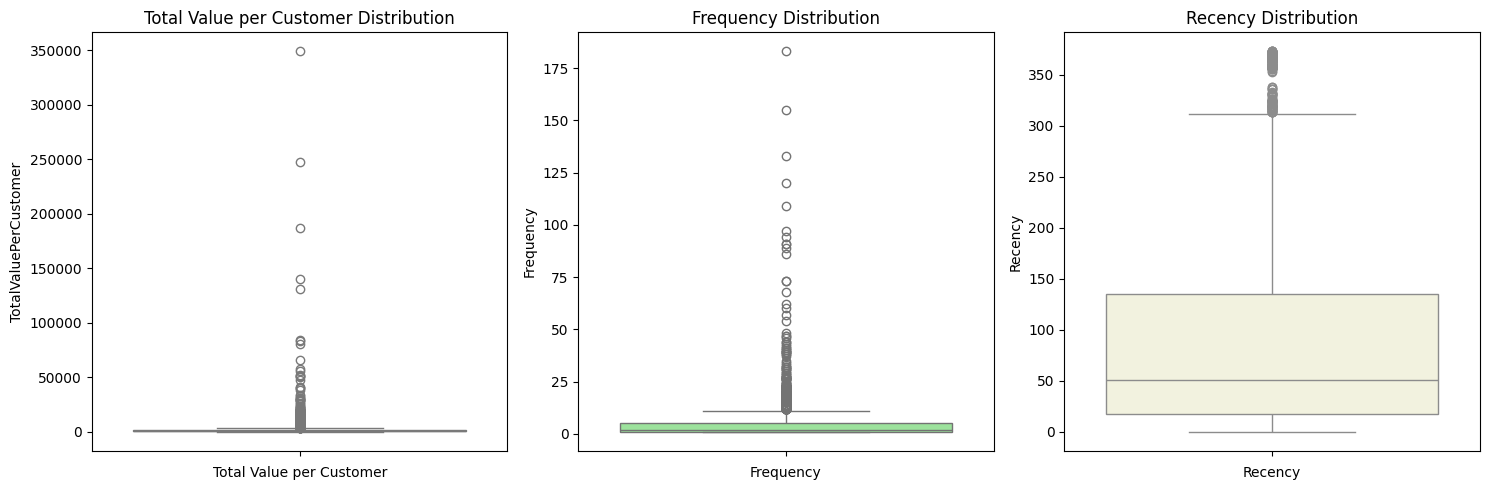

In [461]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=agg_df["TotalValuePerCustomer"], color='lightblue')
plt.title("Total Value per Customer Distribution")
plt.xlabel("Total Value per Customer")

plt.subplot(1, 3, 2)
sns.boxplot(agg_df["Frequency"], color='lightgreen')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")

plt.subplot(1, 3, 3)
sns.boxplot(agg_df["Recency"], color='beige')
plt.title("Recency Distribution")
plt.xlabel("Recency")

plt.tight_layout()
plt.show()

### The boxplots reveal numerous outliers that require careful handling. However, simply removing them is not an option, as a closer examination shows that these outliers represent the most valuable customers — those who place frequent orders and spend significantly more.

#### Instead of dropping these outliers, segmenting the customer base into different tiers will be an option.
- Low-value customers: Those with fewer purchases and lower spending.
- High-value customers: The outliers that spend more and order frequently.

In [465]:
TVPC_Q1 = agg_df["TotalValuePerCustomer"].quantile(0.25)
TVPC_Q3 = agg_df["TotalValuePerCustomer"].quantile(0.75)
TVCP_IQR = TVPC_Q3 - TVPC_Q1

total_value_per_customer_outliers_df = agg_df[(agg_df["TotalValuePerCustomer"] > (TVPC_Q3 + 1.5 * TVCP_IQR)) | (agg_df["TotalValuePerCustomer"] < (TVPC_Q1 - 1.5 * TVCP_IQR))].copy()

total_value_per_customer_outliers_df.describe()

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [469]:
total_value_per_customer_outliers_df.head(5)

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer,Recency
9,12357.00,11229.99,1,2010-11-16 10:05:00,23
25,12380.00,4782.84,4,2010-08-31 14:54:00,100
42,12409.00,12346.62,4,2010-10-15 10:24:00,55
48,12415.00,19468.84,4,2010-11-29 15:07:00,10
61,12431.00,4145.52,11,2010-12-01 10:03:00,8


In [466]:
F_Q1 = agg_df["Frequency"].quantile(0.25)
F_Q3 = agg_df["Frequency"].quantile(0.75)
F_IQR = F_Q3 - F_Q1

freqeuncy_outliers_df = agg_df[(agg_df["Frequency"] > (F_Q3 + 1.5 * F_IQR)) | (agg_df["Frequency"] < (F_Q1 - 1.5 * F_IQR))].copy()

freqeuncy_outliers_df.describe()

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [470]:
freqeuncy_outliers_df.head(5)

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer,Recency
65,12437.00,6834.99,20,2010-11-09 14:46:00,30
84,12471.00,17721.45,44,2010-11-30 14:35:00,9
85,12472.00,10426.48,13,2010-12-05 14:19:00,4
92,12482.00,21941.72,27,2010-05-12 16:51:00,211
115,12523.00,2330.38,12,2010-11-30 12:31:00,9


### To perform data clustering of the customer groups, the data is now being rescaled.

In [468]:
no_outliers_df = agg_df[(~agg_df.index.isin(total_value_per_customer_outliers_df.index)) & (~agg_df.index.isin(freqeuncy_outliers_df.index))]

no_outliers_df.describe()

,Customer ID,TotalValuePerCustomer,Frequency,LastInvoiceDatePerCustomer,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


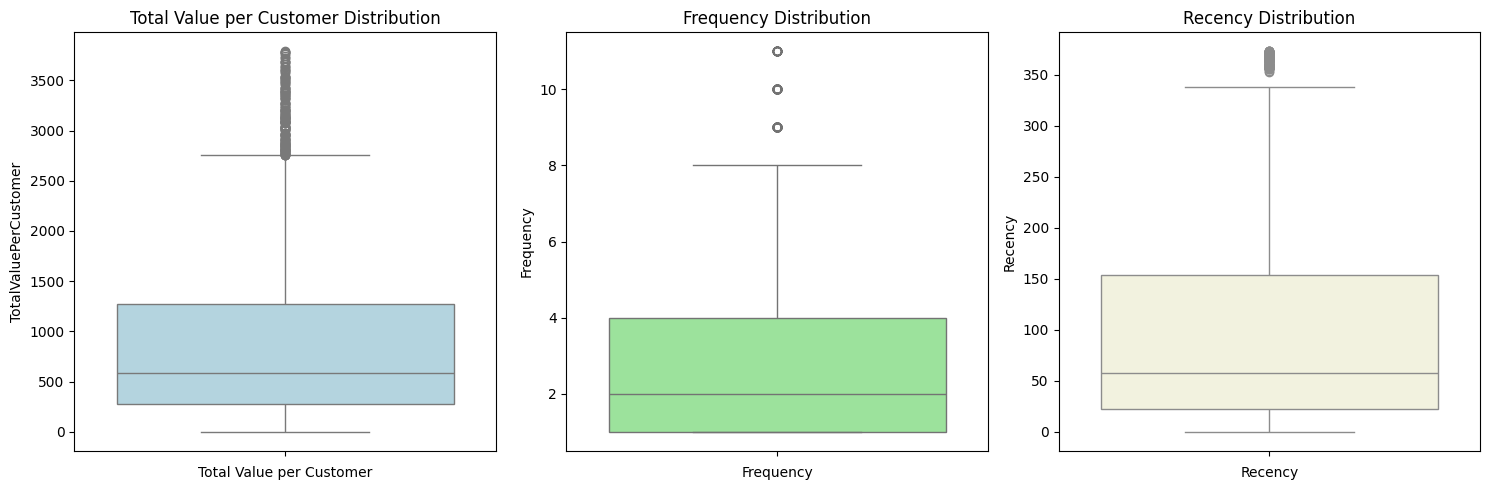

In [471]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=no_outliers_df["TotalValuePerCustomer"], color='lightblue')
plt.title("Total Value per Customer Distribution")
plt.xlabel("Total Value per Customer")

plt.subplot(1, 3, 2)
sns.boxplot(no_outliers_df["Frequency"], color='lightgreen')
plt.title("Frequency Distribution")
plt.xlabel("Frequency")

plt.subplot(1, 3, 3)
sns.boxplot(no_outliers_df["Recency"], color='beige')
plt.title("Recency Distribution")
plt.xlabel("Recency")

plt.tight_layout()
plt.show()